In [1]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='128GB', interface='ib0'
#                       ) 
# cluster.scale(12)
# # cluster.adapt(minimum=10, maximum=196)

client = Client(cluster)
# client = Client(scheduler_file="/home/ad/briolf/scheduler.json")
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/mars4/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46786 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:36678 Dashboard: http://127.0.0.1:46786/status,Cluster Workers: 8 Cores: 56 Memory: 270.19 GB


In [2]:
!squeue -u tuchida

import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 4:
        break
    time.sleep(1)
print(nb_workers)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          11506261      visu      viz  tuchida  R       3:09      1 n4366
24


In [2]:
import xarray as xr
import numpy as np
import numcodecs
import xscale
import gsw
import sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os.path as op
from xhistogram.xarray import histogram as xhist

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02-S/'
xtra = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02X-S/'
scratch = '/scratch/cnt0024/hmg2840/tuchida/temp'
adac = '/scratch/cnt0024/hmg2840/tuchida/SWOT-AdAC/'

In [4]:
regionsy = np.array([[1514-1,2276-1],
                     [1544-1,2278-1],
                     [1908-1,2582-1]
                    ], dtype=int)
regionsx = np.array([[1194-1,1804-1],   # GULFSTR
                     [2664-1,3270-1],   # NANFL
                     [5750-1,6323-1]    # MEDWEST
                    ], dtype=int)
regions = ['GULFSTR','NANFL','MEDWEST']
variables = ['votemper','vosaline','vovecrtz','vomecrty','vozocrtx']

tchunk = -1
xchunk = 100
ychunk = 100
zchunk = 5

<ipython-input-5-07e5fb6119e9>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(dsmask.nav_lon, dsmask.nav_lat, gdepw.where(gdepw>0.))


<xarray.Dataset>
Dimensions:       (x: 610, y: 762, z: 300)
Dimensions without coordinates: x, y, z
Data variables: (12/44)
    nav_lon       (y, x) float32 -78.01 -77.99 -77.97 ... -68.05 -68.04 -68.02
    nav_lat       (y, x) float32 30.0 30.0 30.0 30.0 ... 39.98 39.98 39.98 39.98
    nav_lev       (z) float32 ...
    time_counter  float64 ...
    tmask         (z, y, x) int8 ...
    umask         (z, y, x) int8 ...
    ...            ...
    gdepv         (z, y, x) float32 ...
    gdepw_0       (z, y, x) float32 ...
    gdept_1d      (z) float64 ...
    gdepw_1d      (z) float64 ...
    e3t_1d        (z) float64 ...
    e3w_1d        (z) float64 ...
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  13/07/2018 22:32:53 +0200

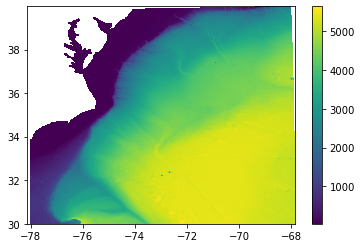

In [5]:
region = 1
ys,ye = regionsy[region-1]
xs,xe = regionsx[region-1]

dsmask = xr.open_dataset(op.join(ddir,'../eNATL60-I/mesh_mask_eNATL60_3.6.nc')
                        ).isel(t=0,y=slice(ys,ye),x=slice(xs,xe))
gdepw = xr.open_dataset(op.join(scratch,'gdepw_eNATL60.nc')
                       ).gdepw.isel(y=slice(ys,ye),x=slice(xs,xe))

fig, ax = plt.subplots()
im = ax.pcolormesh(dsmask.nav_lon, dsmask.nav_lat, gdepw.where(gdepw>0.))
fig.colorbar(im)
dsmask

In [5]:
# dirs = np.arange(669601,756000,43200,dtype=int)
# days = np.concatenate((np.arange(12,32,dtype=int), np.arange(1,6,dtype=int))).reshape((5,5))
# days = np.arange(6,31, dtype=int).reshape((5,5))
# dirs = np.repeat(np.array([1274401]),days.shape[0]+1)
# months = np.array([8,9,10], dtype=str)
# days = np.concatenate((np.concatenate((np.arange(1,32),np.arange(1,31))),np.arange(1,32)))
# mandd = {'8':np.arange(1,32), '9':np.arange(1,31), '10':np.arange(1,32)}
mandd = {'2':np.arange(1,29), '3':np.arange(1,32), '4':np.arange(1,31)}
# print(days,dirs)
mandd.keys()

dict_keys(['2', '3', '4'])

In [ ]:
ks = 0
month = 8
dm = 1
year = 2010
sday = days[ks,0]
eday = days[-1,-1]

for k in range(ks,len(dirs)-1):
#     if k == ks:
#         dd = days[k,-1:]
#     else:
#         dd = days[k]
    dd = days[k]
    for i in dd:
        j = month
        l = j
        m = month+dm
        if i < days[0,0]:
            l = m
        
        dsu = xr.open_dataset(op.join(xtra,
                    '%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridU_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k], 
                                         # 1440721,
                                         int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,
                                         # 25,
                                         days[-1,-1],
                                         year,l,i,year,l,i
                                        ))
                             )
        # if i == days[ks,-1]:
        #     print(dsu)
        tmpu = dsu.vozocrtx.sel(depthu=slice(None,1010)).isel(y=slice(ys,ye),x=slice(xs,xe)
                                                                         ).chunk({'time_counter':-1,'depthu':zchunk,
                                                                                  'y':ychunk,'x':xchunk}
                                                                                ).mean('time_counter',skipna=True
                                                                                      ).compute()
        dsu.close()
        dsv = xr.open_dataset(op.join(xtra,
                    '%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridV_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k], 
                                         # 1440721,
                                         int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,
                                         # 25,
                                         days[-1,-1],
                                         year,l,i,year,l,i
                                        ))
                             )
        tmpv = dsv.vomecrty.sel(depthv=slice(None,1010)).isel(y=slice(ys,ye),x=slice(xs,xe)
                                                                         ).chunk({'time_counter':-1,'depthv':zchunk,
                                                                                  'y':ychunk,'x':xchunk}
                                                                                ).mean('time_counter',skipna=True
                                                                                      ).compute()
        dsv.close()
        dsw = xr.open_dataset(op.join(xtra,
                    '%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridW_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k], 
                                         # 1440721,
                                         int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,
                                         # 25,
                                         days[-1,-1],
                                         year,l,i,year,l,i
                                        ))
                             )
        tmpw = dsw.vovecrtz.sel(depthw=slice(None,1020)).isel(y=slice(ys,ye),x=slice(xs,xe)
                                                                         ).chunk({'time_counter':-1,'depthw':zchunk,
                                                                                  'y':ychunk,'x':xchunk}
                                                                                ).mean('time_counter',skipna=True
                                                                                      ).compute()
        dsw.close()
        dst = xr.open_dataset(op.join(xtra,
                    '%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridT_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k], 
                                         # 1440721,
                                         int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,
                                         # 25,
                                         days[-1,-1],
                                         year,l,i,year,l,i
                                        ))
                             )
        tmpt = dst.votemper.sel(deptht=slice(None,1010)).isel(y=slice(ys,ye),x=slice(xs,xe)
                                                                         ).chunk({'time_counter':-1,'deptht':zchunk,
                                                                                  'y':ychunk,'x':xchunk}
                                                                                ).mean('time_counter',skipna=True
                                                                                      ).compute()
        dst.close()
        dss = xr.open_dataset(op.join(xtra,
                    '%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridS_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k], 
                                         # 1440721,
                                         int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,
                                         # 25,
                                         days[-1,-1],
                                         year,l,i,year,l,i
                                        ))
                             )
        tmps = dss.vosaline.sel(deptht=slice(None,1010)).isel(y=slice(ys,ye),x=slice(xs,xe)
                                                                         ).chunk({'time_counter':-1,'deptht':zchunk,
                                                                                  'y':ychunk,'x':xchunk}
                                                                                ).mean('time_counter',skipna=True
                                                                                      ).compute()
        dss.close()
        if i == sday:
            # print(tmpu.depthu, tmpw.depthw)
            u = tmpu
            v = tmpv
            w = tmpw
            t = tmpt
            s = tmps
        else:
            u = xr.concat([u,tmpu], 'time_counter').chunk({'depthu':zchunk,'y':ychunk,'x':xchunk})
            v = xr.concat([v,tmpv], 'time_counter').chunk({'depthv':zchunk,'y':ychunk,'x':xchunk})
            w = xr.concat([w,tmpw], 'time_counter').chunk({'depthw':zchunk,'y':ychunk,'x':xchunk})
            t = xr.concat([t,tmpt], 'time_counter').chunk({'deptht':zchunk,'y':ychunk,'x':xchunk})
            s = xr.concat([s,tmps], 'time_counter').chunk({'deptht':zchunk,'y':ychunk,'x':xchunk})
            
        
    print(k)

            
dsave = u.to_dataset(name='u')
dsave['v'] = v
dsave['w'] = w
dsave['t'] = t
dsave['s'] = s
dsave['tmask'] = xr.DataArray(dsmask.tmask.isel(z=slice(None,len(t.deptht))).data,
                              dims=t.isel(time_counter=0).dims, coords=t.isel(time_counter=0).coords
                             )
dsave['umask'] = xr.DataArray(dsmask.umask.isel(z=slice(None,len(u.depthu))).data,
                              dims=u.isel(time_counter=0).dims, coords=u.isel(time_counter=0).coords
                             )
dsave['vmask'] = xr.DataArray(dsmask.vmask.isel(z=slice(None,len(v.depthv))).data,
                              dims=v.isel(time_counter=0).dims, coords=v.isel(time_counter=0).coords
                             )
dsave['fmask'] = xr.DataArray(dsmask.fmask.isel(z=slice(None,len(t.deptht))).data,
                              dims=t.isel(time_counter=0).dims, coords=t.isel(time_counter=0).coords
                             )
dsave.coords['time_counter'] = ('time_counter',np.arange(np.datetime64("%4d-%02d-%02d" % (year,j,sday)), 
                                                         np.datetime64("%4d-%02d-%02d" % (year,m,eday+1)), 
                                                         np.timedelta64(1,'D'), dtype='datetime64[D]'))
dsave.coords['depth'] = (('y','x'),gdepw)
dsave.coords['lat'] = (('y','x'),dsmask.nav_lat)
dsave.coords['lon'] = (('y','x'),dsmask.nav_lon)
dsave.coords['e1t'] = (('y','x'),dsmask.e1t)
dsave.coords['e2t'] = (('y','x'),dsmask.e2t)
dsave.coords['e1f'] = (('y','x'),dsmask.e1f)
dsave.coords['e2f'] = (('y','x'),dsmask.e2f)
dsave.coords['e1u'] = (('y','x'),dsmask.e1u)
dsave.coords['e2u'] = (('y','x'),dsmask.e2u)
dsave.coords['e1v'] = (('y','x'),dsmask.e1v)
dsave.coords['e2v'] = (('y','x'),dsmask.e2v)
dsave['e3t_0'] = (('deptht','y','x'),
                  xr.DataArray(dsmask.e3t_0.isel(z=slice(None,len(t.deptht))).data,
                               dims=t.isel(time_counter=0).dims, coords=t.isel(time_counter=0).coords
                              ))
dsave['e3u_0'] = (('depthu','y','x'),
                  xr.DataArray(dsmask.e3u_0.isel(z=slice(None,len(u.depthu))).data,
                               dims=u.isel(time_counter=0).dims, coords=u.isel(time_counter=0).coords
                              ))
dsave['e3v_0'] = (('depthv','y','x'),
                  xr.DataArray(dsmask.e3v_0.isel(z=slice(None,len(v.depthv))).data,
                               dims=v.isel(time_counter=0).dims, coords=v.isel(time_counter=0).coords
                              ))
dsave['e3w_0'] = (('depthw','y','x'),
                  xr.DataArray(dsmask.e3w_0.isel(z=slice(None,len(w.depthw))).data,
                               dims=w.isel(time_counter=0).dims, coords=w.isel(time_counter=0).coords
                              ))
print(dsave)        
compressor = numcodecs.Blosc(cname='snappy', clevel=6, shuffle=-1)
encoding = {vname:{'compressor': compressor} for vname in dsave.variables}
dsave.chunk(chunks={'time_counter':-1,
                    'deptht':zchunk, 'depthu':zchunk, 'depthv':zchunk, 'depthw':zchunk, 
                    'y':ychunk, 'x':xchunk}
           ).to_zarr(op.join(adac,'Interior/region%02d/%4d-%02d-%02d_%4d-%02d-%02d/' 
                             % (region,year,j,sday,year,m,eday)), mode='w')
        
dsave.close()

0
1
2
3


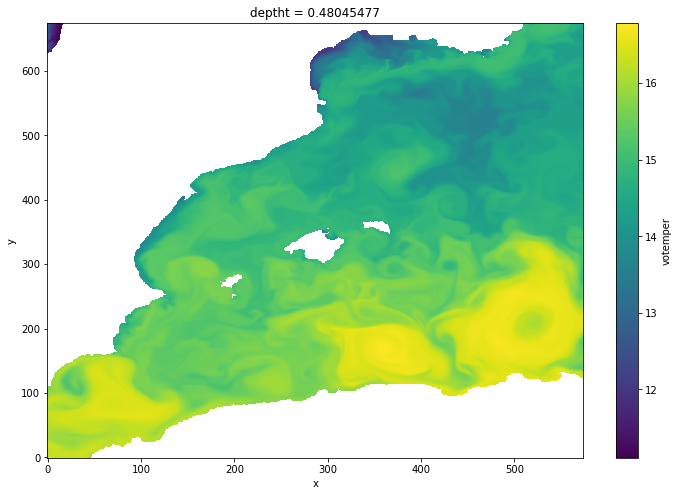

<xarray.Dataset>
Dimensions:       (x: 574, y: 675, z: 300)
Dimensions without coordinates: x, y, z
Data variables: (12/44)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    nav_lev       (z) float32 ...
    time_counter  float64 ...
    tmask         (z, y, x) int8 ...
    umask         (z, y, x) int8 ...
    ...            ...
    gdepv         (z, y, x) float32 ...
    gdepw_0       (z, y, x) float32 ...
    gdept_1d      (z) float64 ...
    gdepw_1d      (z) float64 ...
    e3t_1d        (z) float64 ...
    e3w_1d        (z) float64 ...
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  13/07/2018 22:32:53 +0200 <xarray.Dataset>
Dimensions:   (deptht: 107, depthu: 107, depthv: 107, depthw: 107, x: 574, y: 675)
Coordinates:
  * deptht    (deptht) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
    nav_lat   (y, x) float32 35.49 35.49 35.49 35.49 ... 43.5 43.5 43.5 43.5
    nav_lon   (y, x) float32 -2.001 -1.984 -1.968 -1.951 ... 7.965 7.982 7.9

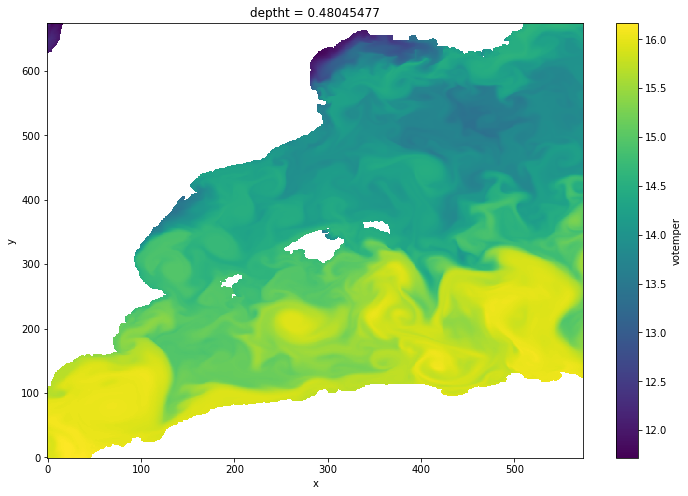

<xarray.Dataset>
Dimensions:       (x: 574, y: 675, z: 300)
Dimensions without coordinates: x, y, z
Data variables: (12/44)
    nav_lon       (y, x) float32 -2.001 -1.984 -1.968 ... 7.965 7.982 7.999
    nav_lat       (y, x) float32 35.49 35.49 35.49 35.49 ... 43.5 43.5 43.5 43.5
    nav_lev       (z) float32 ...
    time_counter  float64 ...
    tmask         (z, y, x) int8 ...
    umask         (z, y, x) int8 ...
    ...            ...
    gdepv         (z, y, x) float32 ...
    gdepw_0       (z, y, x) float32 ...
    gdept_1d      (z) float64 ...
    gdepw_1d      (z) float64 ...
    e3t_1d        (z) float64 ...
    e3w_1d        (z) float64 ...
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  13/07/2018 22:32:53 +0200 <xarray.Dataset>
Dimensions:   (deptht: 107, depthu: 107, depthv: 107, depthw: 107, x: 574, y: 675)
Coordinates:
  * deptht    (deptht) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
    nav_lat   (y, x) float32 35.49 35.49 35.49 35.49 ... 43.5 43.5 43.

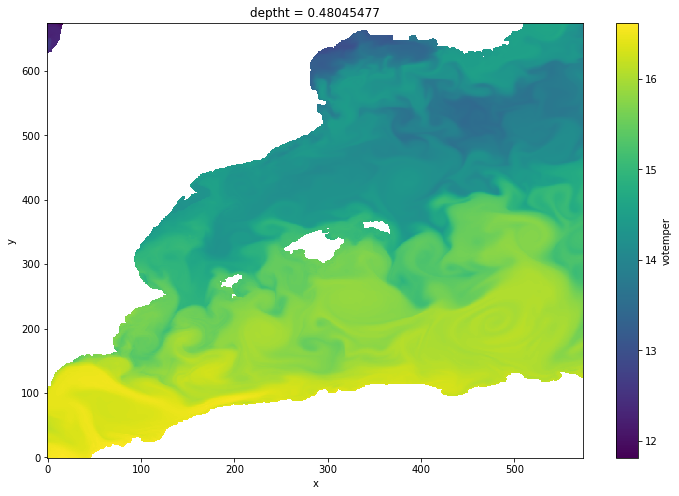

<xarray.Dataset>
Dimensions:       (x: 574, y: 675, z: 300)
Dimensions without coordinates: x, y, z
Data variables: (12/44)
    nav_lon       (y, x) float32 -2.001 -1.984 -1.968 ... 7.965 7.982 7.999
    nav_lat       (y, x) float32 35.49 35.49 35.49 35.49 ... 43.5 43.5 43.5 43.5
    nav_lev       (z) float32 ...
    time_counter  float64 ...
    tmask         (z, y, x) int8 ...
    umask         (z, y, x) int8 ...
    ...            ...
    gdepv         (z, y, x) float32 ...
    gdepw_0       (z, y, x) float32 ...
    gdept_1d      (z) float64 ...
    gdepw_1d      (z) float64 ...
    e3t_1d        (z) float64 ...
    e3w_1d        (z) float64 ...
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  13/07/2018 22:32:53 +0200 <xarray.Dataset>
Dimensions:   (deptht: 107, depthu: 107, depthv: 107, depthw: 107, x: 574, y: 675)
Coordinates:
  * deptht    (deptht) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
    nav_lat   (y, x) float32 35.49 35.49 35.49 35.49 ... 43.5 43.5 43.

In [6]:
year = 2010
rr = 3

for region in regions[int(rr-1):]:

    ys,ye = regionsy[rr-1]
    xs,xe = regionsx[rr-1]

    dsmask = xr.open_dataset(op.join(ddir,'../eNATL60-I/mesh_mask_eNATL60_3.6.nc')
                            ).isel(t=0,y=slice(ys,ye+1),x=slice(xs,xe+1))
    gdepw = xr.open_dataset(op.join(scratch,'gdepw_eNATL60.nc')
                           ).gdepw.isel(y=slice(ys,ye+1),x=slice(xs,xe+1))
    
    if region == 'NANFL':
        months = list(mandd.keys())[1:]
    else:
        months = list(mandd.keys())
    # months = list(mandd.keys())
    for mm in months:
        for dd in mandd[mm]:
            for variable in variables:
                
                if len(region) == 7:
                    var = xr.open_dataset(op.join(adac,
                                'Interior/BLBT02/%7s/eNATL60%7s-BLBT02_y%4dm%02dd%02d.1h_%8s_0-1000m.nc'
                                                  % (region,region,year,int(mm),dd,variable))
                                         )[variable].chunk({'y':ychunk,'x':xchunk}
                                                          ).mean('time_counter',skipna=True
                                                                ).compute()
                else:
                    var = xr.open_dataset(op.join(adac,
                                'Interior/BLBT02/%5s/eNATL60%5s-BLBT02_y%4dm%02dd%02d.1h_%8s_0-1000m.nc'
                                                  % (region,region,year,int(mm),dd,variable))
                                         )[variable].chunk({'y':ychunk,'x':xchunk}
                                                          ).mean('time_counter',skipna=True
                                                                ).compute()
                
                if variable[-1] == 'y':
                    mask = dsmask.vmask.isel(z=slice(None,len(var.depthv)))
                elif variable[-1] == 'x':
                    mask = dsmask.umask.isel(z=slice(None,len(var.depthu)))
                elif variable[-1] == 'z':
                    mask = dsmask.tmask.isel(z=slice(None,len(var.depthw)))
                else:
                    mask = dsmask.tmask.isel(z=slice(None,len(var.deptht)))
                    
                if variable == variables[0]:
                    if dd == mandd[mm][0]:
                        fig, ax = plt.subplots(figsize=(12,8))
                        var.where(xr.DataArray(mask.data, dims=var.dims,
                                               coords=var.coords)!=0.).isel(deptht=0).plot(ax=ax)
                        plt.show()
                    tmp = var.where(xr.DataArray(mask.data, dims=var.dims,
                                                 coords=var.coords)!=0.).to_dataset(name=variable)
                else:
                    tmp[variable] = var.where(xr.DataArray(mask.data, dims=var.dims,
                                                           coords=var.coords)!=0.)
                del var
                        
            if dd == mandd[mm][0]:
                print(dsmask, tmp)
                dsave = tmp
            else:
                dsave = xr.concat([dsave, tmp], 'time_counter')
            tmp.close()
            del tmp
    
        dsave['tmask'] = xr.DataArray(dsmask.tmask.isel(z=slice(None,len(dsave.deptht))).data,
                                      dims=dsave.votemper.isel(time_counter=0).dims, 
                                      coords=dsave.votemper.isel(time_counter=0).coords
                                     )
        dsave['umask'] = xr.DataArray(dsmask.umask.isel(z=slice(None,len(dsave.depthu))).data,
                                      dims=dsave.vozocrtx.isel(time_counter=0).dims, 
                                      coords=dsave.vozocrtx.isel(time_counter=0).coords
                                     )
        dsave['vmask'] = xr.DataArray(dsmask.vmask.isel(z=slice(None,len(dsave.depthv))).data,
                                      dims=dsave.vomecrty.isel(time_counter=0).dims, 
                                      coords=dsave.vomecrty.isel(time_counter=0).coords
                                     )
        dsave['fmask'] = xr.DataArray(dsmask.fmask.isel(z=slice(None,len(dsave.deptht))).data,
                                      dims=dsave.votemper.isel(time_counter=0).dims, 
                                      coords=dsave.votemper.isel(time_counter=0).coords
                                     )
        dsave.coords['time_counter'] = ('time_counter',np.arange(np.datetime64("%4d-%02d-%02d" 
                                                                               % (year,int(mm),1)), 
                                                                 np.datetime64("%4d-%02d-%02d" 
                                                                               % (year,int(mm)+1,1)), 
                                                                 np.timedelta64(1,'D'), dtype='datetime64[D]'))
        dsave.coords['depth'] = (('y','x'),gdepw)
        dsave.coords['lat'] = (('y','x'),dsmask.nav_lat)
        dsave.coords['lon'] = (('y','x'),dsmask.nav_lon)
        dsave.coords['e1t'] = (('y','x'),dsmask.e1t)
        dsave.coords['e2t'] = (('y','x'),dsmask.e2t)
        dsave.coords['e1f'] = (('y','x'),dsmask.e1f)
        dsave.coords['e2f'] = (('y','x'),dsmask.e2f)
        dsave.coords['e1u'] = (('y','x'),dsmask.e1u)
        dsave.coords['e2u'] = (('y','x'),dsmask.e2u)
        dsave.coords['e1v'] = (('y','x'),dsmask.e1v)
        dsave.coords['e2v'] = (('y','x'),dsmask.e2v)
        dsave['e3t_0'] = (('deptht','y','x'),
                          xr.DataArray(dsmask.e3t_0.isel(z=slice(None,len(dsave.deptht))).data,
                                       dims=dsave.votemper.isel(time_counter=0).dims, 
                                       coords=dsave.votemper.isel(time_counter=0).coords
                                      ))
        dsave['e3u_0'] = (('depthu','y','x'),
                          xr.DataArray(dsmask.e3u_0.isel(z=slice(None,len(dsave.depthu))).data,
                                       dims=dsave.vozocrtx.isel(time_counter=0).dims, 
                                       coords=dsave.vozocrtx.isel(time_counter=0).coords
                                      ))
        dsave['e3v_0'] = (('depthv','y','x'),
                          xr.DataArray(dsmask.e3v_0.isel(z=slice(None,len(dsave.depthv))).data,
                                       dims=dsave.vomecrty.isel(time_counter=0).dims, 
                                       coords=dsave.vomecrty.isel(time_counter=0).coords
                                      ))
        dsave['e3w_0'] = (('depthw','y','x'),
                          xr.DataArray(dsmask.e3w_0.isel(z=slice(None,len(dsave.depthw))).data,
                                       dims=dsave.vovecrtz.isel(time_counter=0).dims, 
                                       coords=dsave.vovecrtz.isel(time_counter=0).coords
                                      ))

        if len(variable) == 7:
            dsave.to_netcdf(op.join(adac,'Interior/BLBT02/%7s/Region%02d-interior-daily_%4d-%02d.nc'
                                    % (region,rr,year,int(mm)))
                           )
        else:
            dsave.to_netcdf(op.join(adac,'Interior/BLBT02/%5s/Region%02d-interior-daily_%4d-%02d.nc'
                                    % (region,rr,year,int(mm)))
                           )
        print(dsave)
        dsave.close()
        del dsave
    rr += 1

In [7]:
client.close()